# clEsperanto
[clEsperanto](http://clesperanto.net) is a project based on [OpenCL](https://www.khronos.org/opencl/), an open standard for programming graphics processing units (GPUs, and more) and its python wrapper [pyopencl](https://documen.tician.de/pyopencl/). Under the hood, it uses processing kernels originating from the [clij](https://clij.github.io) project.

See also
* [GPU-accelerated image analysis in Fiji and Napari, EuroBioimaging Virtual Pub](https://www.youtube.com/watch?v=MERVnf5_QkI)
* [pyclesperanto-prototype](https://github.com/clEsperanto/pyclesperanto_prototype)
* [pyclesperanto API](https://clij.github.io/clij2-docs/reference__pyclesperanto)
* [Napari pyclesperanto Assistant](https://clesperanto.github.io/napari_pyclesperanto_assistant/)

## GPU Initialization
We'll start with initializing checking out what GPUs are installed:

In [1]:
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import stackview

# list available devices
cle.available_device_names()

['NVIDIA GeForce RTX 3050 Ti Laptop GPU',
 'gfx1035',
 'cupy backend (experimental)']

In [2]:
# select a specific device with only a part of its name
cle.select_device("TX")

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

In [3]:
# check which device is uses right now
cle.get_device()

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

## Processing images
For loading image data, we use scikit-image as usual:

StackViewNDArray([[ 40,  32,  24, ..., 216, 200, 200],
                  [ 56,  40,  24, ..., 232, 216, 216],
                  [ 64,  48,  24, ..., 240, 232, 232],
                  ...,
                  [ 72,  80,  80, ...,  48,  48,  48],
                  [ 80,  80,  80, ...,  48,  48,  48],
                  [ 96,  88,  80, ...,  48,  48,  48]], dtype=uint8)
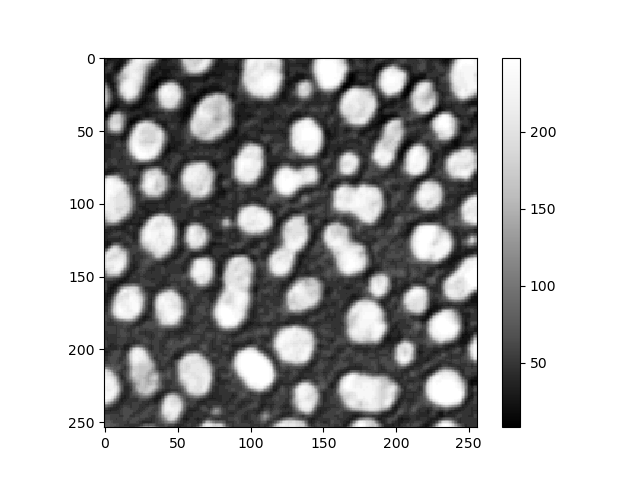
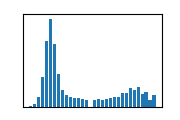

In [4]:
from skimage.io import imread

image = imread("../03b_image_processing/data/blobs.tif")
stackview.insight(image)

The `cle.` gateway has all methods you need, it does not have sub-packages:

c:\structure\code\pyclesperanto_prototype\pyclesperanto_prototype\_tier9\_imshow.py:34: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


cl.OCLArray([[ 41.42875 ,  34.69644 ,  27.733936, ..., 220.92714 , 211.21162 ,
        206.71573 ],
       [ 47.421425,  38.878723,  30.323011, ..., 228.32323 , 220.60194 ,
        216.83534 ],
       [ 48.121433,  40.610855,  33.357384, ..., 235.32935 , 229.7049  ,
        226.8882  ],
       ...,
       [ 74.4386  ,  76.32904 ,  77.03725 , ...,  48.00032 ,  48.00075 ,
         48.001007],
       [ 81.793655,  81.17787 ,  79.80763 , ...,  48.      ,  48.      ,
         48.      ],
       [ 88.816925,  85.382095,  81.478806, ...,  48.      ,  48.      ,
         48.      ]], dtype=float32)
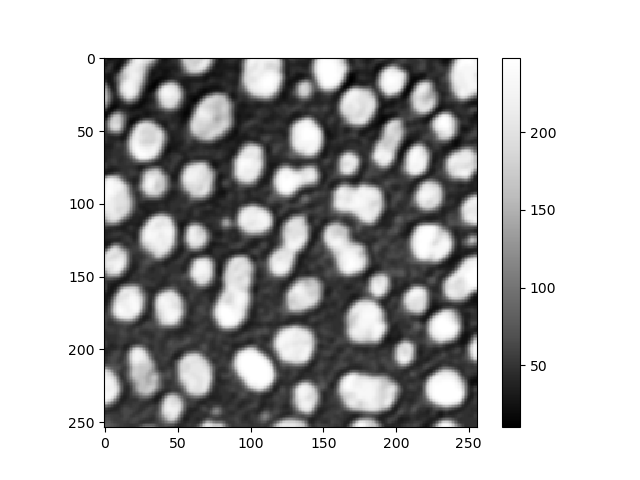
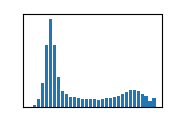

In [5]:
# noise removal
blurred = cle.gaussian_blur(image, sigma_x=1, sigma_y=1)
blurred

c:\structure\code\pyclesperanto_prototype\pyclesperanto_prototype\_tier9\_imshow.py:34: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


cl.OCLArray([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
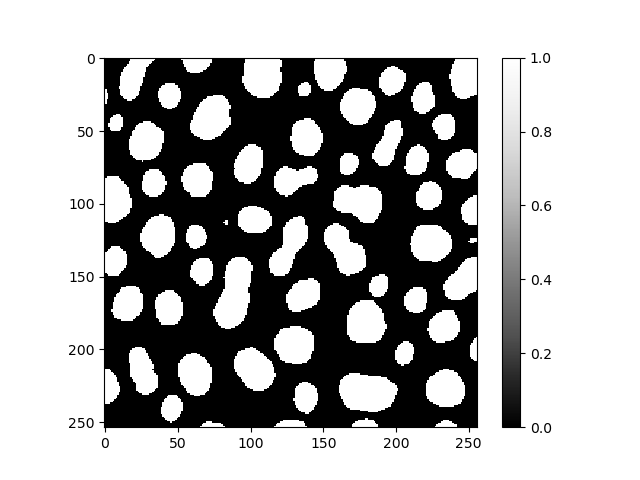
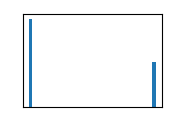

In [6]:
# binarization
binary = cle.threshold_otsu(blurred)
binary

c:\structure\code\pyclesperanto_prototype\pyclesperanto_prototype\_tier9\_imshow.py:34: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


cl.OCLArray([[ 0,  0,  0, ..., 59, 59, 59],
       [ 0,  0,  0, ..., 59, 59, 59],
       [ 0,  0,  0, ..., 59, 59, 59],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
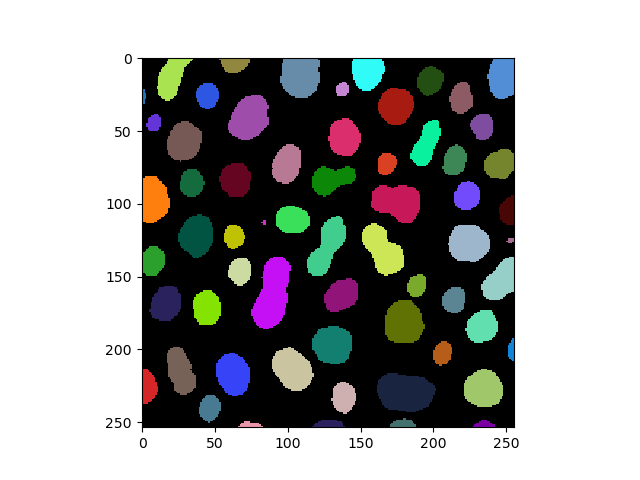

In [7]:
# labeling
labels = cle.connected_components_labeling_box(binary)
labels

Some of these operations, e.g. [voronoi_otsu_labeling](https://nbviewer.jupyter.org/github/clEsperanto/pyclesperanto_prototype/blob/master/demo/segmentation/voronoi_otsu_labeling.ipynb) are in fact short-cuts and combine a number of operations such as Gaussian blur, Voronoi-labeling and Otsu-thresholding to go from a raw image to a label image directly:

cl.OCLArray([[ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
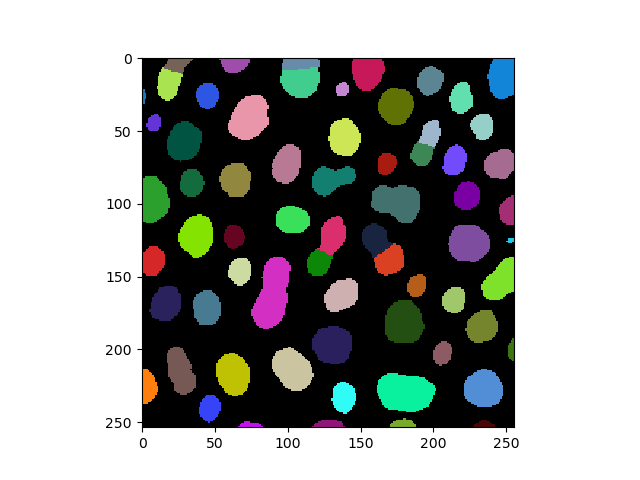

In [8]:
labels = cle.voronoi_otsu_labeling(image, spot_sigma=3.5, outline_sigma=1)
labels

## Memory management
In jupyter noteboooks, variables are kept alive as long as the notebook kernel is running. Thus, your GPU may fill up with memory. Thus, if you don't need an image anymore, remove it from memory using `del`. It will then be remove from GPU memory thanks to [pyopencl](https://documen.tician.de/pyopencl/) magic.

In [9]:
del image
del blurred
del binary
del labels